We should have built an environment for the PHM data challenge now. So, we can start to do our task directly.

For a task like this, we first need to understand our task and our data. We will use the `PHM data challenge 2016` as an example to demonstrate the workflow of doing this project.

## Understand the project and data format
As the `PHM16DataChallengeCFP.pdf` stated, our task is "This year the challenge is focused on tracking the health state of components within a wafer chemical‐mechanical planarization (polishing) system. " and "Participants will be scored based on their ability to predict average removal rate of material during polishing at particular tool settings and as the performance of the tool degrades over time." This means we need to **predict** *average removal rate* given the tools' settings and state.

The data, like in `data/2016 PHM Data Challenge/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-data/training/CMP-training-001.csv`, gives the parameters for the tools and devices, which would be the input features of our model; and data in `data/2016 PHM Data Challenge/2016 PHM DATA CHALLENGE CMP DATA SET/CMP-training-removalrate.csv` gives the removal rate, which would be the target output of our model. The test set is the data set used to assess our model by the host, and we need to use the training data to train our model. Thus, a train test split(a function provided by scikit-learn) would be needed to split the training data into a training set and a validation set. 

We know our job now, but we have data scattered in different files. Before we can do anything, we need to compile the scatered data into one complete file. This can be done automatically with the help of Python.

What we need to do next is get the data ready. We have to load the data and do some preprocessing. Some exploration of the data will help us choosing the right model.

## Load the Data

In [4]:
# First, we need to import the libraries we need.
# I will try to constrain our usage of libraries to the
# libraries we installed in `set up environment` and 
# python standard libraries

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import glob # the python std lib used for searching for files automatically,
            # we can also construct the file list mannually, such as
            # [f"CMP-training-{i}.csv" for i in range(185)] if that makes you 
            # feel more comfort. I am worried about missing files here

# the file names are in pattern
file_pattern = "CMP-training-*.csv"
# the path to the files, we have to use a raw string to bypass the messy windows path
path = r".\data\2016 PHM Data Challenge\2016 PHM DATA CHALLENGE CMP DATA SET\CMP-data\training"

# searching the files
files = glob.glob(path + "\\" + file_pattern)

# sort the files by name to maintainn the order
files.sort()

# initialise a list to keep the data frames of the files
data_frames = []

for file in files:
    df = pd.read_csv(file)
    data_frames.append(df)

# we need to combine all the data frames into one single set of data
raw_features = pd.concat(data_frames, axis=0, ignore_index=True) # axis = 0 means stack vertically insteaded of 
                                                             # horizontally. ignore_index will reconstruct 
                                                             # the index for rows
raw_targets = pd.read_csv(r".\data\2016 PHM Data Challenge\2016 PHM DATA CHALLENGE CMP DATA SET\CMP-training-removalrate.csv")

# you have not loaded the data, and you can check the data with some commonly used methods
# use head()/tail() methods to show the first/last 5 rows
# or you can use head(n)/tail(n) to show the first/last n rows
print(raw_features.head())
print("****************************************************")
print(raw_features.head())
print("****************************************************")
print(raw_features.tail())
print("****************************************************")
print(raw_targets.head())
print("****************************************************")

# use the shape attribute to show the shape of the data frame
# note that shape is not a method, but an attribute
print("shape of the raw features:\n{}".format(raw_features.shape))
print("shape of the raw targets: \n{}".format(raw_targets.shape))
print("****************************************************")

# use the info() method to show the information about the data frame
print("raw features info: \n{}".format(raw_features.info()))
print("****************************************************")
print("raw targets info: \n{}".format(raw_targets.info()))
print("****************************************************")

# the describe() method to give out the statistical description of our data
print("raw features statistics: \n{}".format(raw_features.describe()))
print("****************************************************")
print("raw targets statistics: \n{}".format(raw_targets.describe()))

raw

C:\Users\Galanodel\AppData\Local\Temp\ipykernel_2556\3689711778.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  raw_features = pd.concat(data_frames, axis=0, ignore_index=True) # axis = 0 means stack vertically insteaded of


  MACHINE_ID MACHINE_DATA     TIMESTAMP   WAFER_ID STAGE  CHAMBER  \
0          2            1  4.816371e+08  371447024     A      1.0   
1          2            1  4.816371e+08  371447024     A      1.0   
2          2            1  4.816371e+08  371447024     A      1.0   
3          2            1  4.816371e+08  371447024     A      1.0   
4          2            1  4.816371e+08  371447024     A      1.0   

   USAGE_OF_BACKING_FILM  USAGE_OF_DRESSER  USAGE_OF_POLISHING_TABLE  \
0                 9302.5        534.074074                292.592593   
1                 9302.5        534.074074                292.592593   
2                 9302.5        534.074074                292.592593   
3                 9302.5        534.074074                292.592593   
4                 9302.5        534.074074                292.592593   

   USAGE_OF_DRESSER_TABLE  ...  USAGE_OF_MEMBRANE  USAGE_OF_PRESSURIZED_SHEET  \
0                 2666.25  ...         110.306324                     2

NameError: name 'raw' is not defined

## Save the intermediate as checkpoint

In [6]:
# we can now save the intermediate data for further process
import os

path = r"./data/process"
if not os.path.exists(path):
    os.makedirs(path)

raw_features.to_csv(os.path.join(path, "raw_features.csv"), index=False)
raw_targets.to_csv(os.path.join(path, "raw_targets.csv"), index=False) 


## Data unification
By combining and merging our data into a single, unified dataset, we can do some cleaning and analysis.

In [7]:
# Now, we have our intermediate data ready, and 
# saved safety on our disk
#
# The next step would be trying to combine the training
# features and targets into a single dataset.
# This big dataset can give us some information on the 
# relation between input features and output targets


# we need to use the merge method here because we want a join
# of the 2 data frames instead of stacking them together
raw_training = pd.merge(raw_features, raw_targets, on=["WAFER_ID", "STAGE"], how='inner')


# we can check the info() of the dataset and we can check 
# the first lines to see the data examples
#raw_training.info()
raw_training.head(300)  # from the rows of raw_features.csv and raw_targets.csv, we know that there should be about 300
                        # sensor readings for each avg_removal_rate

,MACHINE_ID,MACHINE_DATA,TIMESTAMP,WAFER_ID,STAGE,CHAMBER,USAGE_OF_BACKING_FILM,USAGE_OF_DRESSER,USAGE_OF_POLISHING_TABLE,USAGE_OF_DRESSER_TABLE,...,USAGE_OF_PRESSURIZED_SHEET,SLURRY_FLOW_LINE_A,SLURRY_FLOW_LINE_B,SLURRY_FLOW_LINE_C,WAFER_ROTATION,STAGE_ROTATION,HEAD_ROTATION,DRESSING_WATER_STATUS,EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
0,2,1,4.816371e+08,371447024,A,1.0,9302.500000,534.074074,292.592593,2666.25,...,2790.75,2.222222,0.909091,565.6,34.651163,0.0,156.8,1.0,60.909091,149.13090
1,2,1,4.816371e+08,371447024,A,1.0,9302.500000,534.074074,292.592593,2666.25,...,2790.75,2.222222,0.909091,568.4,34.651163,0.0,156.8,1.0,60.909091,149.13090
2,2,1,4.816371e+08,371447024,A,1.0,9302.500000,534.074074,292.592593,2666.25,...,2790.75,2.222222,0.909091,568.4,34.651163,0.0,156.8,1.0,60.909091,149.13090
3,2,1,4.816371e+08,371447024,A,1.0,9302.500000,534.074074,292.592593,2666.25,...,2790.75,2.222222,0.909091,568.4,34.651163,0.0,156.8,1.0,60.606061,149.13090
4,2,1,4.816371e+08,371447024,A,1.0,9302.500000,534.074074,292.592593,2666.25,...,2790.75,2.222222,0.909091,571.2,34.651163,0.0,156.8,1.0,60.909091,149.13090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2,1,4.816397e+08,371447028,A,1.0,9356.666667,536.296296,341.481481,2667.75,...,2807.00,0.000000,0.000000,0.0,0.000000,0.0,160.0,1.0,0.000000,152.04915
296,2,1,4.816397e+08,371447028,A,1.0,9356.666667,536.296296,341.481481,2667.75,...,2807.00,0.000000,0.000000,0.0,0.000000,0.0,160.0,1.0,0.000000,152.04915
297,2,1,4.816397e+08,371447028,A,1.0,9356.666667,536.296296,341.481481,2667.75,...,2807.00,0.000000,0.000000,0.0,0.000000,0.0,160.0,1.0,0.000000,152.04915
298,2,1,4.816397e+08,371447028,A,1.0,9356.666667,536.296296,341.481481,2667.75,...,2807.00,0.000000,0.000000,0.0,0.000000,0.0,160.0,1.0,0.000000,152.04915


we can see that we have build our whole training data set succefully, and everything seem fine according to the info and first 20 lines.
But we still need to do a thorough data cleaning incase there are problems we haven't noticed in our data


## Data Cleaning
The basics of data cleaning should at least check for ***Missing Data*** (like null or NaN values in our data) ***Duplicate Data*** (we have to check the identical rows, or same features with same targets to decide if should be in the dataset) and ***Wrong Data Types*** (there could be strings in inter value columns and so on, are these wrong types of data just typo, or data corruption).

We will check our data step by step.

In [8]:
# --------------------check for missing data----------------------------------

# .isnull() creates a DataFrame of the same size, 
# with True where a value is missing and False where it is not.
# .sum() then sums up the True values for each column (since True=1 and False=0).
missing_values = raw_training.isnull().sum()
print(missing_values)
print(missing_values.shape)

# We only want to see the columns that actually have missing values.
# So, we filter the series to show only counts greater than 0.
columns_with_missing_values = missing_values[missing_values > 0]


print("---------------------------------------------------")
if columns_with_missing_values.empty:
    print("No missing values found in the entire dataset.")
else:
    print("Found missing values in the following columns:")
    print(missing_values)
    # for small amount of null values, we can just drop them
    raw_training.dropna(axis=0, how='any')  # the axis=0 means drop data rows with null, 
                                            # axis=1 means drop columns containing null
                                            # how='any' means drop the row if any field
                                            # of the row is null, you can also choose 
                                            # how='all' if you can tolerate partial missing values
    # In some cases, the missing values can be restored, and you can use .fillna() method to fill them
    # back, this process is called impute

MACHINE_ID                      0
MACHINE_DATA                    0
TIMESTAMP                       0
WAFER_ID                        0
STAGE                           0
CHAMBER                         0
USAGE_OF_BACKING_FILM           0
USAGE_OF_DRESSER                0
USAGE_OF_POLISHING_TABLE        0
USAGE_OF_DRESSER_TABLE          0
PRESSURIZED_CHAMBER_PRESSURE    0
MAIN_OUTER_AIR_BAG_PRESSURE     0
CENTER_AIR_BAG_PRESSURE         0
RETAINER_RING_PRESSURE          0
RIPPLE_AIR_BAG_PRESSURE         0
USAGE_OF_MEMBRANE               0
USAGE_OF_PRESSURIZED_SHEET      0
SLURRY_FLOW_LINE_A              0
SLURRY_FLOW_LINE_B              0
SLURRY_FLOW_LINE_C              0
WAFER_ROTATION                  0
STAGE_ROTATION                  0
HEAD_ROTATION                   0
DRESSING_WATER_STATUS           0
EDGE_AIR_BAG_PRESSURE           0
AVG_REMOVAL_RATE                0
dtype: int64
(26,)
---------------------------------------------------
No missing values found in the entire dataset

In [9]:
# ------------------ Check for fully duplicated rows -------------------------------------

# similar to .isnull(), .duplicated().sum() counts rows that are an exact copy of a row that appeared earlier.
num_full_duplicates = raw_training.duplicated().sum()
print(f"Number of fully duplicated rows: {num_full_duplicates}")

# --- Check for a more critical problem: duplicate polish results ---
# Does the same (WAFER_ID, STAGE) combination appear with different removal rates?
# We check this on the original `removal_rate_df` before the merge.
num_id_duplicates = raw_targets.duplicated(subset=['WAFER_ID', 'STAGE']).sum()
print(f"Number of duplicate WAFER_ID/STAGE pairs in the results file: {num_id_duplicates}")


Number of fully duplicated rows: 1819
Number of duplicate WAFER_ID/STAGE pairs in the results file: 0


In [10]:
# we can see that there are 1819 duplicated data in the raw_training data set. 
# the fully duplicated data are obviously not right, they recored the state of a wafer
# with same sensor readings at some same time points.
#
# we should jsut drop the data with confidence in this case. and luckily, we did not 
# met id dumplicate.

print("original shape of raw training data: {}".format(raw_training.shape))

raw_training = raw_training.drop_duplicates(keep='first')

print("new raw training data with no dumplicate: {}".format(raw_training.shape))

original shape of raw training data: (672744, 26)
new raw training data with no dumplicate: (670925, 26)


In [11]:
# check the data type is trivial because pandas will notify you when loading the data
# if there are some data type conflict.
# but we will check it again here with the .info() method

raw_training.info()

# and we can not save the data set to a file because this is the most clean data we 
# have right now
raw_training.to_csv(os.path.join(path, "raw_training.csv"), index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 670925 entries, 0 to 672743
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   MACHINE_ID                    670925 non-null  object 
 1   MACHINE_DATA                  670925 non-null  object 
 2   TIMESTAMP                     670925 non-null  float64
 3   WAFER_ID                      670925 non-null  object 
 4   STAGE                         670925 non-null  object 
 5   CHAMBER                       670925 non-null  float64
 6   USAGE_OF_BACKING_FILM         670925 non-null  float64
 7   USAGE_OF_DRESSER              670925 non-null  float64
 8   USAGE_OF_POLISHING_TABLE      670925 non-null  float64
 9   USAGE_OF_DRESSER_TABLE        670925 non-null  float64
 10  PRESSURIZED_CHAMBER_PRESSURE  670925 non-null  float64
 11  MAIN_OUTER_AIR_BAG_PRESSURE   670925 non-null  float64
 12  CENTER_AIR_BAG_PRESSURE       670925 non-null  fl

## DATA exploration

We now have our cleaned, unified training data ready. We still need to do some exploration to get a better understanding of the data. This step will be helpful for deciding models on fitting the data.

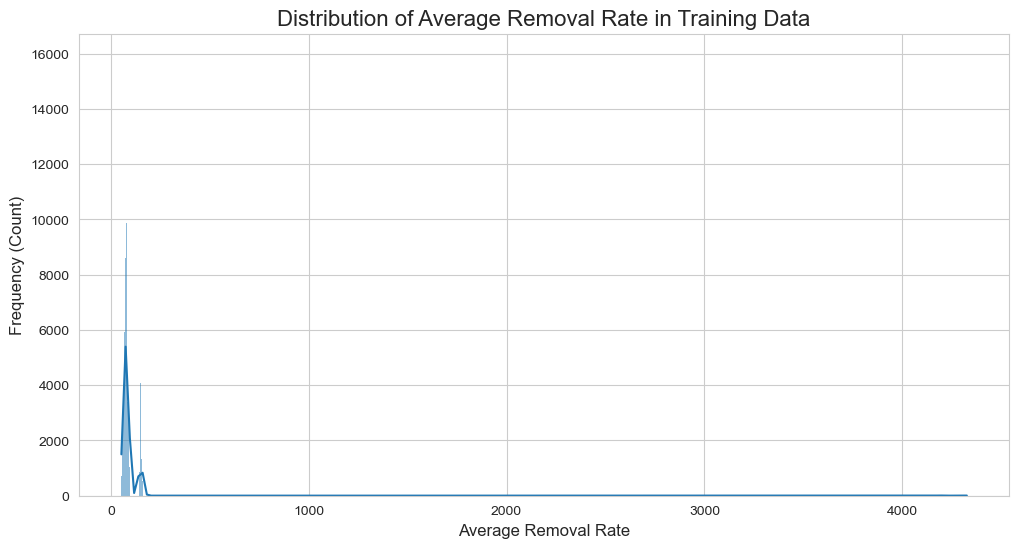

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional style for our plots
sns.set_style("whitegrid")

# --- Plot the distribution of our target variable ---

# Create a figure with a specific size for better readability
plt.figure(figsize=(12, 6))

# sns.histplot() is a powerful function to create histograms.
# We use the full train_df here, but the removal rate is the same for all timestamps of a given polish.
sns.histplot(data=raw_training, x='AVG_REMOVAL_RATE', kde=True, bins='auto')

# Add clear titles and labels
plt.title('Distribution of Average Removal Rate in Training Data', fontsize=16)
plt.xlabel('Average Removal Rate', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)

# Display the plot
plt.show()

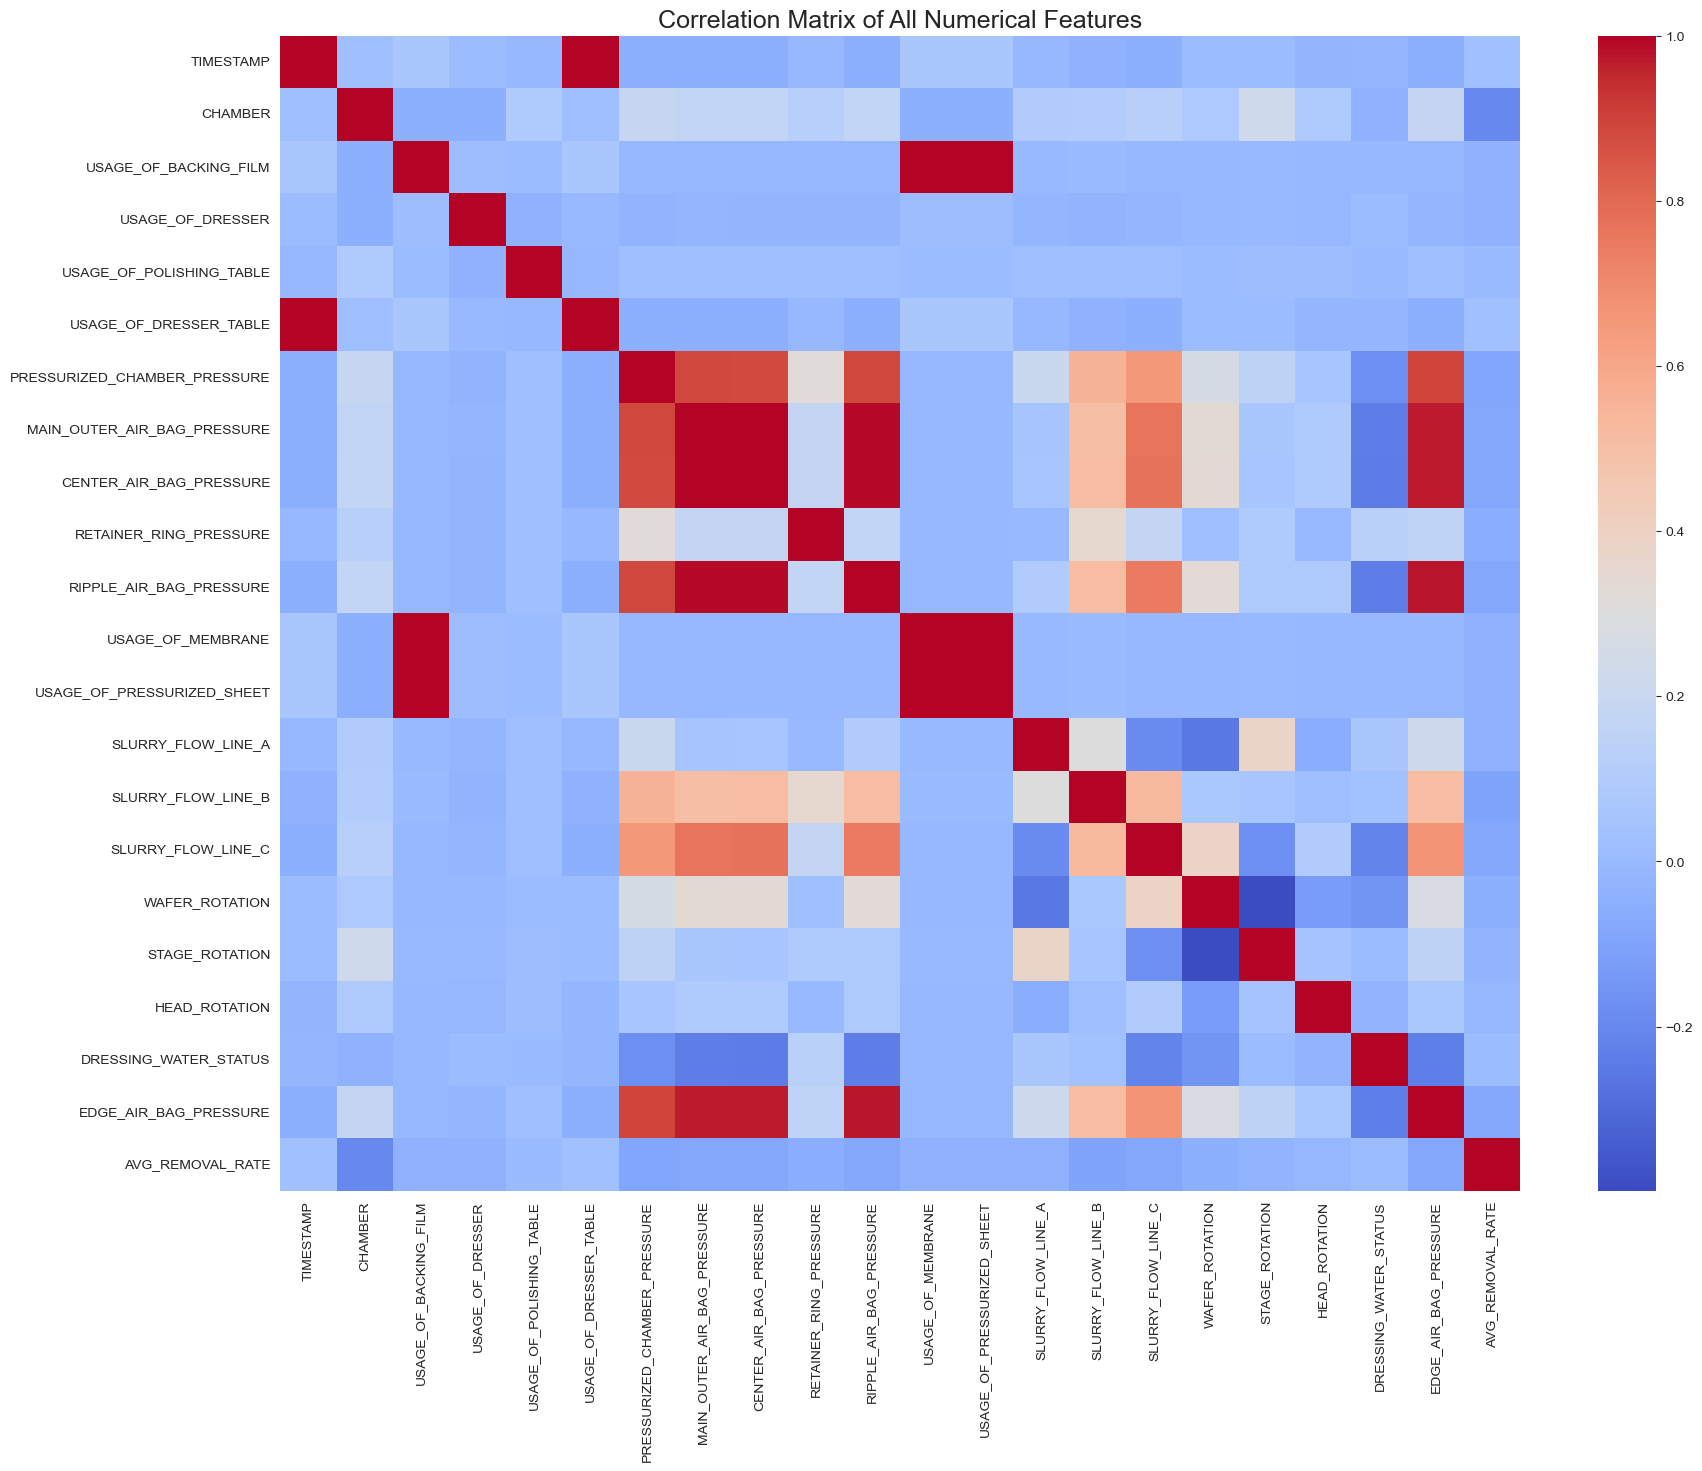

In [20]:
# .corr() calculates the pairwise correlation of columns.
# It's computationally intensive, so it might take a moment.
correlation_matrix = raw_training.corr(numeric_only=True)

# --- Visualizing the Correlation Matrix as a Heatmap ---

# Create a large figure to make the heatmap readable
plt.figure(figsize=(20, 15))

# sns.heatmap() is the function to create the plot.
# - correlation_matrix: The data to plot.
# - cmap='coolwarm': A good color map where positive correlations are warm (red)
#                  and negative correlations are cool (blue).
# - annot=False: We won't write the numbers on the squares because there are too many.
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)

plt.title('Correlation Matrix of All Numerical Features', fontsize=18)
plt.savefig('corralation matrix')
plt.show()

Original DataFrame had 670925 rows.
Summary DataFrame has 1981 rows (one per polish).


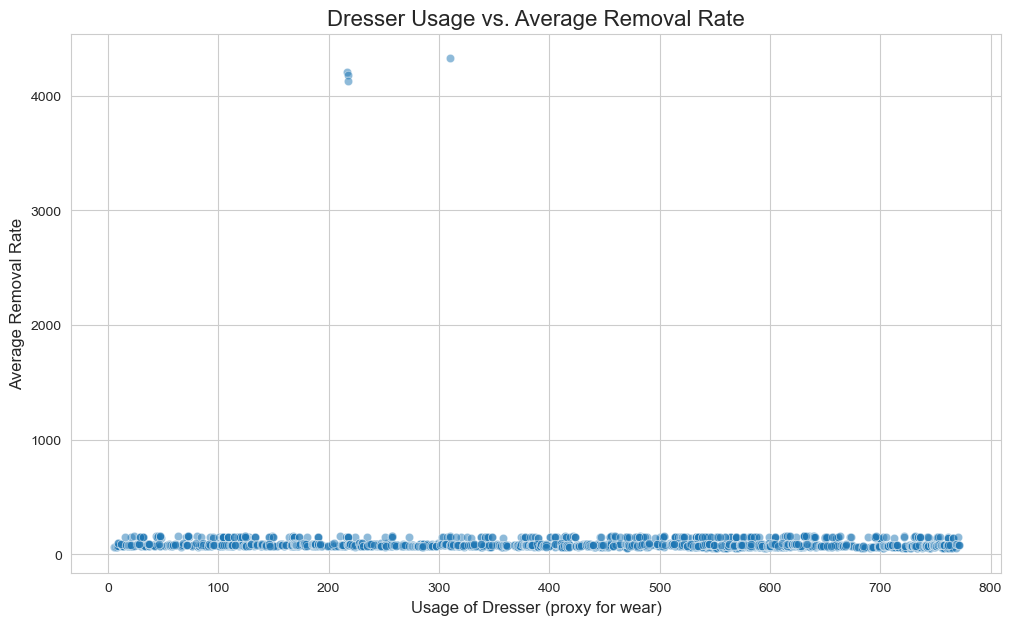

In [21]:
# --- Create a summary DataFrame with one row per polish ---
# We use .drop_duplicates() to keep only the first row for each unique (WAFER_ID, STAGE) pair.
# This gives us a clean dataset for plotting relationships between overall polish characteristics.
polishes_summary = raw_training.drop_duplicates(subset=['WAFER_ID', 'STAGE'])

print(f"Original DataFrame had {len(raw_training)} rows.")
print(f"Summary DataFrame has {len(polishes_summary)} rows (one per polish).")

# --- Create Scatter Plot for Dresser Usage ---
plt.figure(figsize=(12, 7))

sns.scatterplot(data=polishes_summary, x='USAGE_OF_DRESSER', y='AVG_REMOVAL_RATE', alpha=0.5)

plt.title('Dresser Usage vs. Average Removal Rate', fontsize=16)
plt.xlabel('Usage of Dresser (proxy for wear)', fontsize=12)
plt.ylabel('Average Removal Rate', fontsize=12)
plt.grid(True)
plt.savefig('dresser usage vs arr')
plt.show()

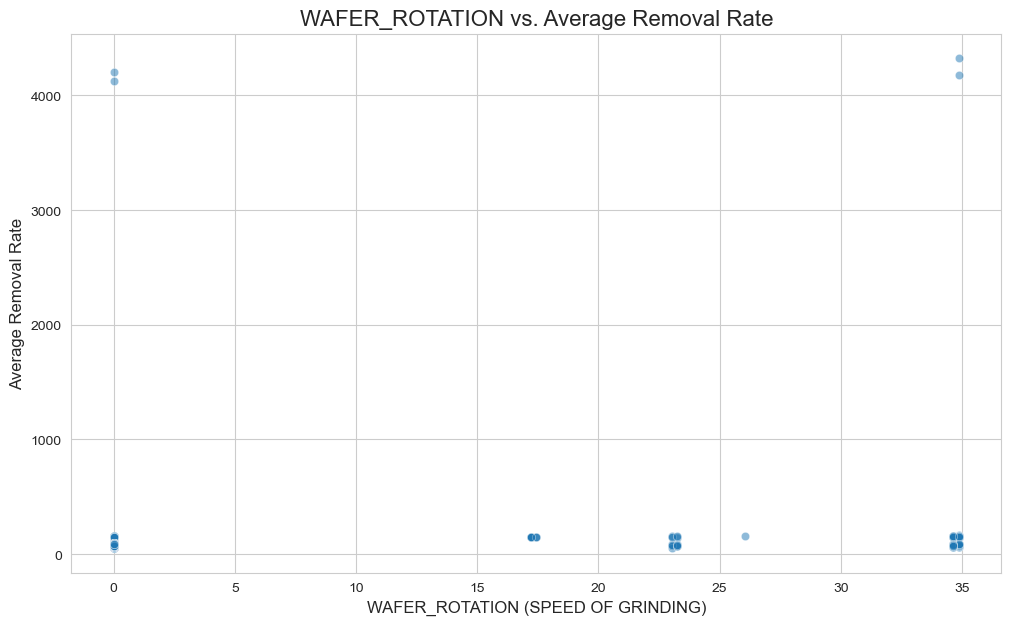

In [22]:
# --- Create Scatter Plot for Dresser Usage ---
plt.figure(figsize=(12, 7))

sns.scatterplot(data=polishes_summary, x='WAFER_ROTATION', y='AVG_REMOVAL_RATE', alpha=0.5)

plt.title('WAFER_ROTATION vs. Average Removal Rate', fontsize=16)
plt.xlabel('WAFER_ROTATION (SPEED OF GRINDING)', fontsize=12)
plt.ylabel('Average Removal Rate', fontsize=12)
plt.grid(True)
plt.savefig('wr vs arr')
plt.show()

In [23]:
# Use the summary DataFrame for a clean view
polishes_summary = raw_training.drop_duplicates(subset=['WAFER_ID', 'STAGE'])

# Let's get a statistical summary of the removal rate
print(polishes_summary['AVG_REMOVAL_RATE'].describe())



count    1981.000000
mean       98.631645
std       187.429160
min        53.426550
25%        72.376500
50%        79.154850
75%        88.702050
max      4326.154050
Name: AVG_REMOVAL_RATE, dtype: float64


Investigating 1977 polishes with 'normal' removal rates.



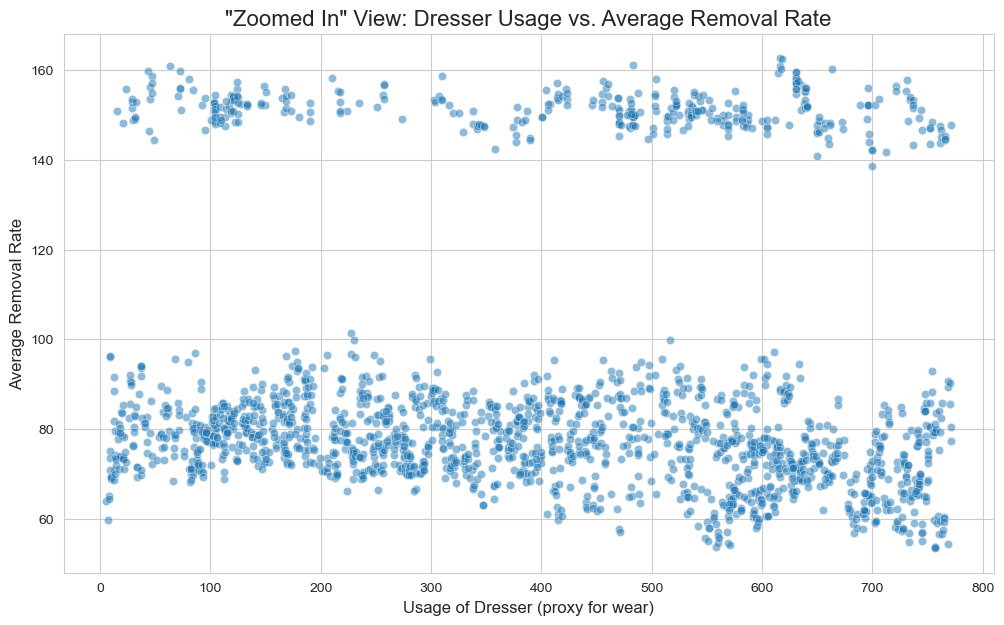

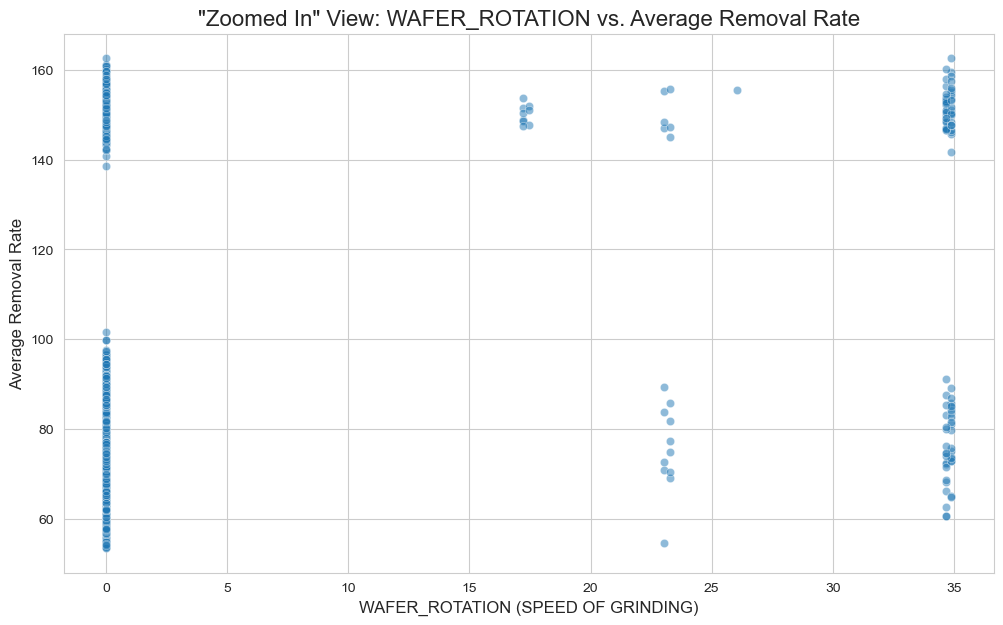

In [25]:
# Let's define a threshold. Based on the plots, a value like 500 seems safe.
# We are creating a new DataFrame containing only the "normal" polishes.
normal_polishes = polishes_summary[polishes_summary_df['AVG_REMOVAL_RATE'] < 2000]

print(f"Investigating {len(normal_polishes)} polishes with 'normal' removal rates.\n")


# --- Re-run the Scatter Plot for Dresser Usage on the FILTERED data ---
plt.figure(figsize=(12, 7))

sns.scatterplot(data=normal_polishes, x='USAGE_OF_DRESSER', y='AVG_REMOVAL_RATE', alpha=0.5)

plt.title('"Zoomed In" View: Dresser Usage vs. Average Removal Rate', fontsize=16)
plt.xlabel('Usage of Dresser (proxy for wear)', fontsize=12)
plt.ylabel('Average Removal Rate', fontsize=12)
plt.grid(True)
plt.savefig('normal polishes')
plt.show()


# --- Re-run the Scatter Plot for WAFER_ROTATION on the FILTERED data ---
plt.figure(figsize=(12, 7))

sns.scatterplot(data=normal_polishes, x='WAFER_ROTATION', y='AVG_REMOVAL_RATE', alpha=0.5)

plt.title('"Zoomed In" View: WAFER_ROTATION vs. Average Removal Rate', fontsize=16)
plt.xlabel('WAFER_ROTATION (SPEED OF GRINDING)', fontsize=12)
plt.ylabel('Average Removal Rate', fontsize=12)
plt.grid(True)
plt.show()

We can clearly see that the average removal rate is quite correlated with certain parameters but also exhibits distinct layers, with gaps of approximately 120 and 2000 separating the groups. Thus, this problem involves both classification and regression tasks, requiring targeted feature engineering.
> The Three Main Families of Feature Engineering Techniques  
>
> We can group most techniques into three broad categories.   
> I. Feature Creation: Inventing New Information
>
> This is the most creative part, where your domain knowledge (physics here) shines. You are creating new columns (features) from existing ones.  
>
> A. Time-Series Aggregations (Crucial for our CMP problem):   
> Our current data is a time series (many measurements over time for one event), but our prediction is for the event as a whole. We must collapse the time-series information into a set of summary statistics.  
>
>   Central Tendency: What was the typical value during the process?  
>
>       mean(): The average sensor reading.  
>
>       median(): The middle value (robust to outliers).  
>
>   Dispersion & Volatility: How much did the value fluctuate?  
>
>       std(): Standard deviation. A measure of spread.  
>
>       min(), max(): The minimum and maximum values reached.  
>
>       range = max - min: The full range of values.  
>
>       quantile(): e.g., the 25th and 75th percentiles.  
>
>   Trend & Shape: In which direction was the value heading?  
>
>       Slope: Fit a simple linear regression to the time-series (y = sensor_value, x = timestamp) and use the slope as a feature. A positive slope means the pressure was increasing.  
>
>       Change over Time: The value at the end of the process minus the value at the start.  
>
> B. Interaction Features:  
> These features capture the interplay between two or more existing features.  
>
>   Products: feature_A * feature_B. Example: HEAD_ROTATION * RETAINER_RING_PRESSURE. Perhaps the combination of high speed and high pressure is what's truly predictive.  
>
>   Ratios: feature_A / feature_B. Example: MAIN_OUTER_AIR_BAG_PRESSURE / CENTER_AIR_BAG_PRESSURE. This captures the balance of pressures, which might be more important than the absolute values.  
>
>   Differences: feature_A - feature_B.  
>
>   Polynomial Features: Create feature_A^2, feature_B^2, feature_A * feature_B, etc. This allows linear models to learn non-linear relationships.  
>
> C. Domain-Specific Features (Your Physics Intuition):   
> This is where you add knowledge from outside the dataset.  
>
>   Wear-and-Tear Proxies: We already have USAGE_OF_DRESSER. Could we create a feature like TIME_SINCE_LAST_PAD_CHANGE if we had that data?  
>
>   Known Physical Formulas: If you knew a formula from material science that related pressure, speed, and slurry flow to abrasion, you could calculate that value and use it as a powerful new feature.  
>
> II. Feature Transformation: Improving Existing Features  
>
> Sometimes a feature has a good signal, but it's in a format the model can't easily use. We transform it to make it more digestible.  
>
> A. Handling Skewness:  
> If a feature's histogram is heavily skewed (like our AVG_REMOVAL_RATE was, but in one direction), some models struggle.  
>
>   Log Transform: np.log1p(feature). log1p handles zeros gracefully. This can turn an exponentially growing feature into a linear one.  
>
>   Box-Cox Transform: A more advanced, data-driven transformation to make a feature more normally distributed.  

> B. Scaling & Normalization:
> Many models (like Support Vector Machines, Neural Networks, and anything using regularization) are sensitive to the scale of features. A feature that ranges from 0-1000 will dominate a feature that ranges from 0-1. We must put them on a level playing field.  
>
>   StandardScaler: Transforms features to have a mean of 0 and a standard deviation of 1. This is the most common choice. (x - mean) / std_dev  
>
>   MinMaxScaler: Rescales features to a specific range, typically [0, 1]. (x - min) / (max - min)  
>
> C. Discretization (Binning):  
> Sometimes it's better to treat a continuous numerical feature as a categorical one.  
>
>   Example: Instead of using AGE as a number (21, 22, 23...), you could bin it into categories like Young, Middle-Aged, Senior.  
>
>   For our problem, we could bin USAGE_OF_DRESSER into New_Dresser, Used_Dresser, Worn_Dresser. This can sometimes capture non-linear effects more simply.  
>
> III. Feature Selection: Removing Bad Features  
>
> Not all features are helpful. Some are irrelevant (noise) and some are redundant (provide the same information as another feature). Removing them can lead to simpler, faster, and sometimes even more accurate models.  
>
> A. Filtering Methods:  
> These methods rank features based on some statistical score and you take the top K.
>
>   Correlation: Remove features that are highly correlated with each other (e.g., > 0.95), keeping only one. Why tell the model the same thing twice?  
>
>   Mutual Information: Measures how much information a feature provides about the target variable (works for both classification and regression).  
>
> B. Wrapper Methods:  
> These methods use a predictive model to score subsets of features.  
>
>   Recursive Feature Elimination (RFE): Start with all features, train a model, remove the weakest feature, and repeat until you reach the desired number of features. 
>
> C. Embedded Methods:  
The model itself performs feature selection during training.  
>
>   L1 (Lasso) Regularization: This technique penalizes model complexity and can force the coefficients of useless features to become exactly zero, effectively removing them.  
>
>   Tree-based Models (Random Forest, Gradient Boosting): These models naturally calculate "feature importance" scores, telling you which features they relied on most for their predictions. You can use these scores to discard the least important ones.  

In [36]:
# ===  Feature Engineering Pipeline  ===

import pandas as pd
import numpy as np
import os

# Start with a Fresh Load of the Merged Data ---
# This ensures we have a clean slate every time we run this block.
processed_data_path = r'.\data\process'

# This is the full, merged DataFrame
train_df = pd.read_csv(os.path.join(processed_data_path, 'raw_training.csv'))
print(f"Loaded and merged data, shape: {train_df.shape}")

# --- Create the Classification Target  ---
# We MUST create the 'REMOVAL_RATE_MODE' column before we can use it.
bins = [-np.inf, 120, 4000, np.inf]
labels = [0, 1, 2] # 0: Low, 1: Medium, 2: High
train_df['REMOVAL_RATE_MODE'] = pd.cut(train_df['AVG_REMOVAL_RATE'], bins=bins, labels=labels)
print("Created the 3-Class 'REMOVAL_RATE_MODE' target column.")
print(train_df['REMOVAL_RATE_MODE'].value_counts().sort_index())
print("\n")


# --- Engineer the Aggregate Features ---
print("--- Starting Feature Engineering ---")

time_varying_cols = [col for col in train_df.columns if col not in [
    'WAFER_ID', 'STAGE', 'MACHINE_ID', 'TIMESTAMP', 
    'USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER', 'USAGE_OF_POLISHING_TABLE', 
    'USAGE_OF_DRESSER_TABLE', 'USAGE_OF_MEMBRANE', 'USAGE_OF_PRESSURIZED_SHEET',
    'AVG_REMOVAL_RATE', 'REMOVAL_RATE_MODE'
]]
constant_cols = ['USAGE_OF_DRESSER', 'USAGE_OF_POLISHING_TABLE']

aggregations = {col: ['mean', 'std', 'min', 'max'] for col in time_varying_cols}
for col in constant_cols:
    aggregations[col] = ['mean']

features_df = train_df.groupby(['WAFER_ID', 'STAGE']).agg(aggregations)
features_df.columns = ['_'.join(col).strip() for col in features_df.columns.values]

# --- Create Aligned Target Variables ---
targets_df = train_df.groupby(['WAFER_ID', 'STAGE'])[['REMOVAL_RATE_MODE', 'AVG_REMOVAL_RATE']].first()

# --- Combine into a Final Analysis DataFrame ---
analysis_df = pd.concat([features_df, targets_df], axis=1)

print("\nFeature Engineering Complete.")
print(f"Created a new analysis DataFrame with {analysis_df.shape[0]} rows and {analysis_df.shape[1]} columns.")

Loaded and merged data, shape: (670925, 26)
Created the 3-Class 'REMOVAL_RATE_MODE' target column.
REMOVAL_RATE_MODE
0    569664
1    100210
2      1051
Name: count, dtype: int64


--- Starting Feature Engineering ---

Feature Engineering Complete.
Created a new analysis DataFrame with 1981 rows and 64 columns.


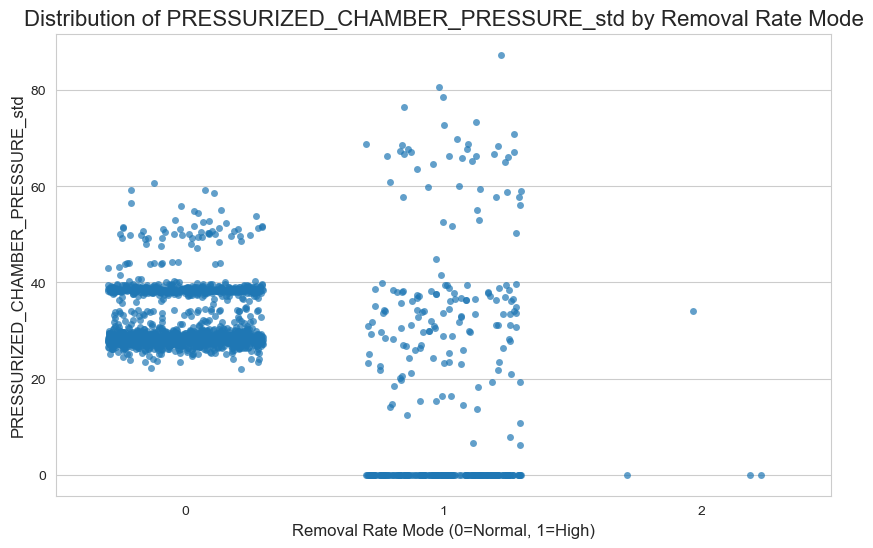

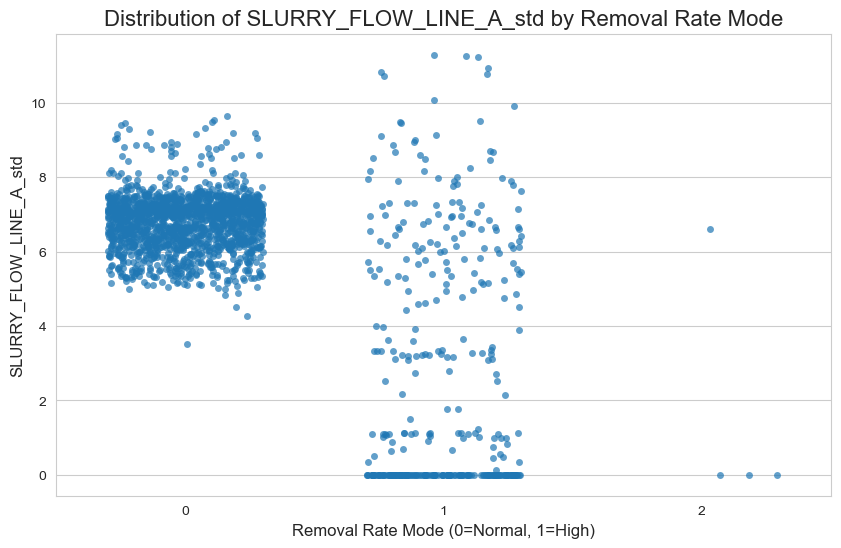

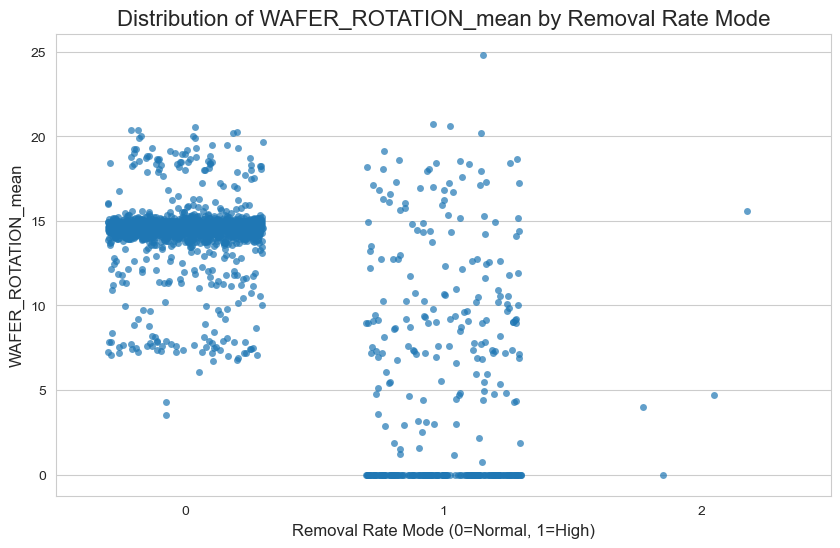

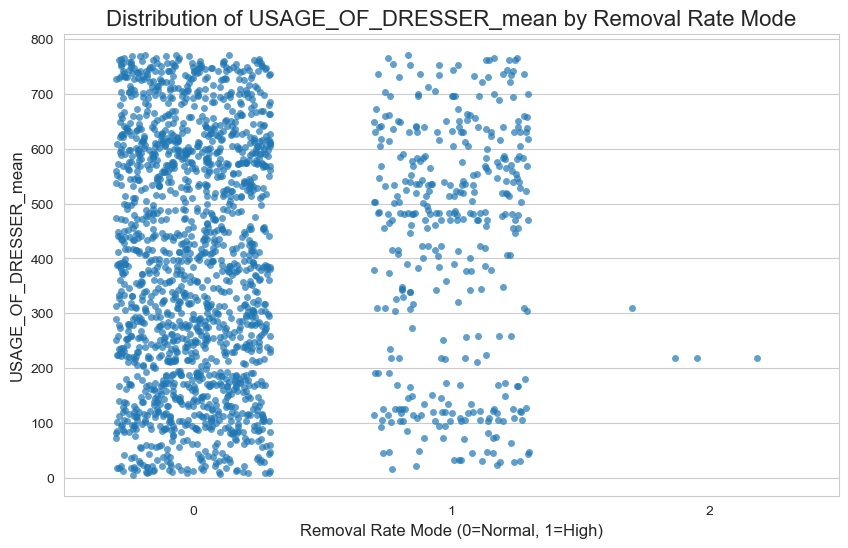

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Let's pick a few candidate features to investigate for classification
# The standard deviation ('std') often captures instability, which might signal a different mode.
classifier_candidate_features = [
    'PRESSURIZED_CHAMBER_PRESSURE_std',
    'SLURRY_FLOW_LINE_A_std',
    'WAFER_ROTATION_mean',
    'USAGE_OF_DRESSER_mean'
]

for feature in classifier_candidate_features:
    plt.figure(figsize=(10, 6))
    
    # sns.stripplot is similar to swarmplot and works well here
    sns.stripplot(data=analysis_df, x='REMOVAL_RATE_MODE', y=feature, jitter=0.3, alpha=0.7)
    
    plt.title(f'Distribution of {feature} by Removal Rate Mode', fontsize=16)
    plt.xlabel('Removal Rate Mode (0=Normal, 1=High)', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.show()

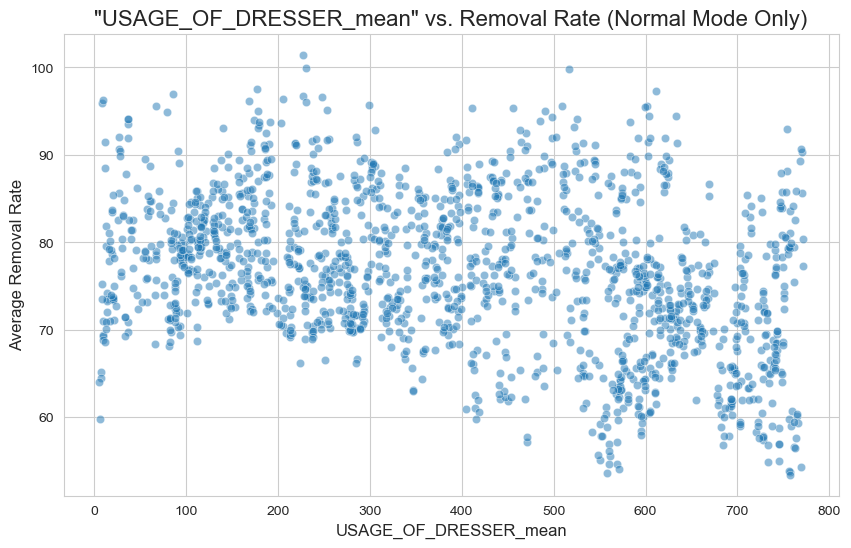

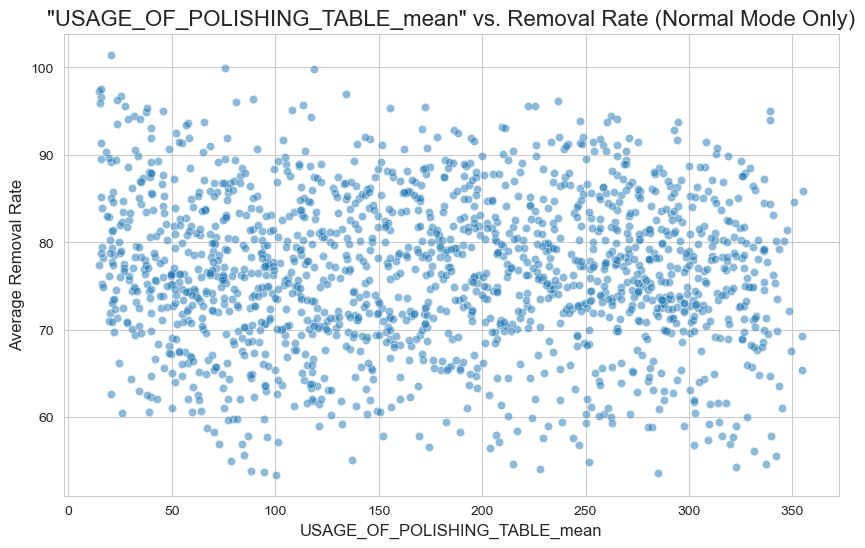

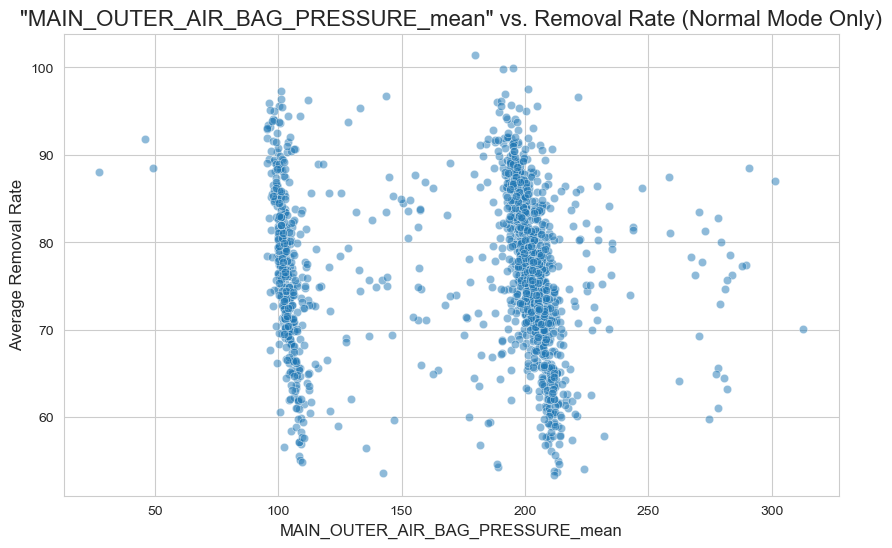

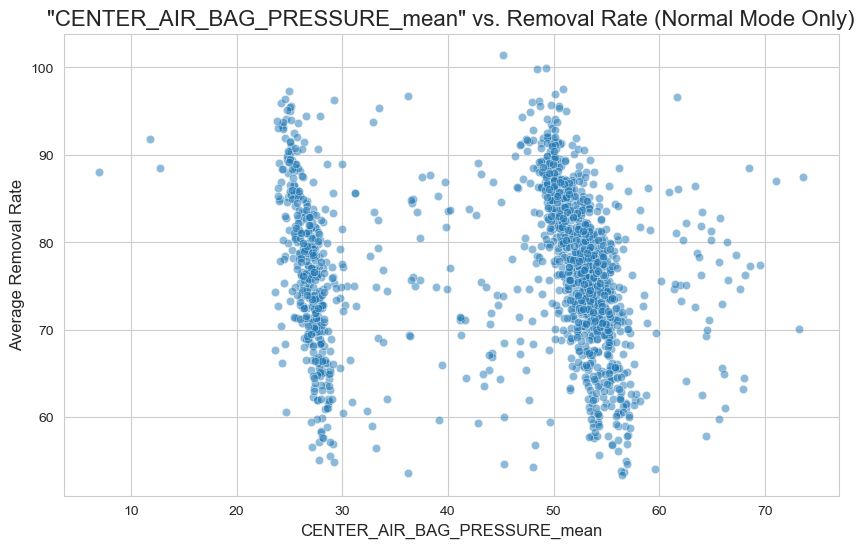

In [39]:
# First, create a DataFrame containing only the "Normal" mode data
normal_mode_df = analysis_df[analysis_df['REMOVAL_RATE_MODE'] == 0]

# Candidate features for our "Normal" regressor
regressor_candidate_features = [
    'USAGE_OF_DRESSER_mean',
    'USAGE_OF_POLISHING_TABLE_mean',
    'MAIN_OUTER_AIR_BAG_PRESSURE_mean',
    'CENTER_AIR_BAG_PRESSURE_mean'
]

for feature in regressor_candidate_features:
    plt.figure(figsize=(10, 6))
    
    # We plot the feature vs. the actual removal rate for this subset of data
    sns.scatterplot(data=normal_mode_df, x=feature, y='AVG_REMOVAL_RATE', alpha=0.5)
    
    plt.title(f'"{feature}" vs. Removal Rate (Normal Mode Only)', fontsize=16)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Average Removal Rate', fontsize=12)
    plt.grid(True)
    plt.show()

--- Investigating Regression Trends for LOW Mode (Rate < 120) ---


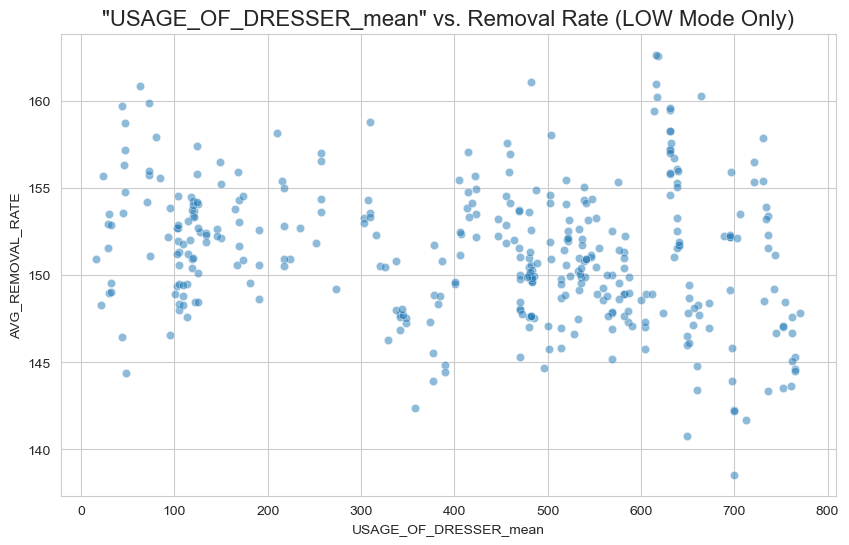

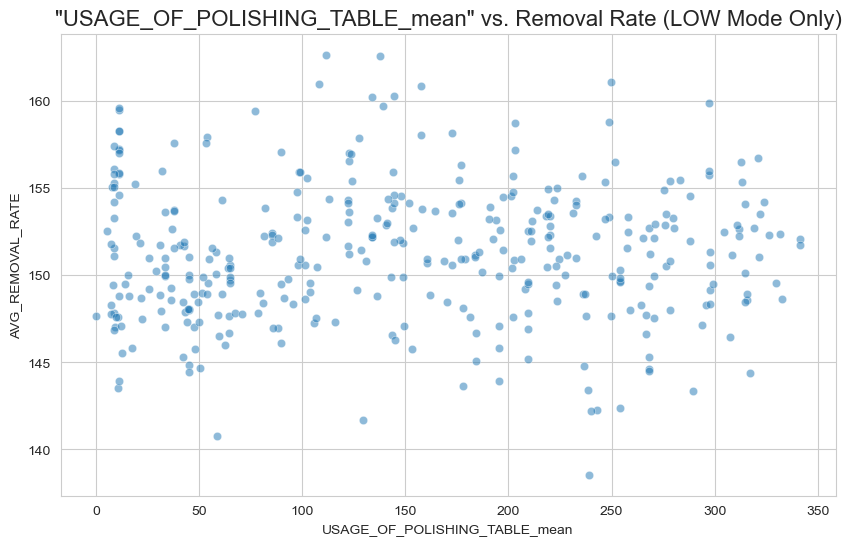

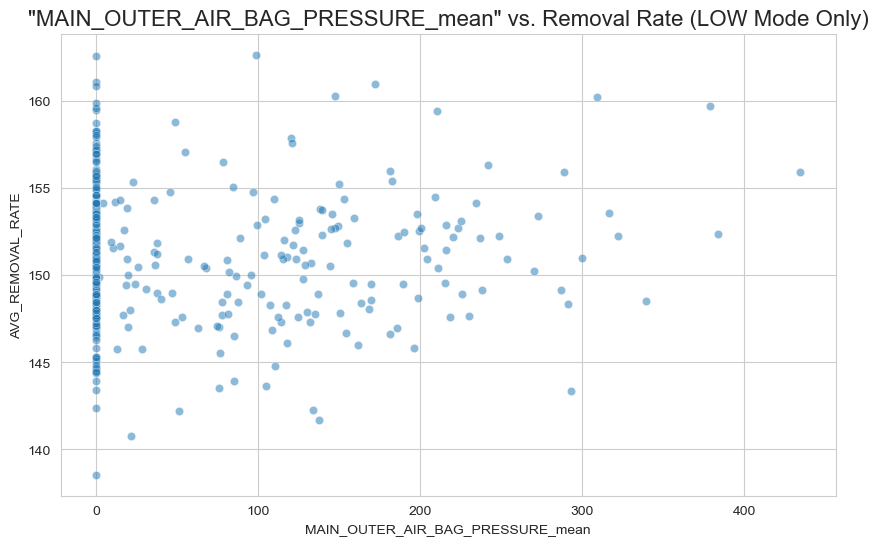

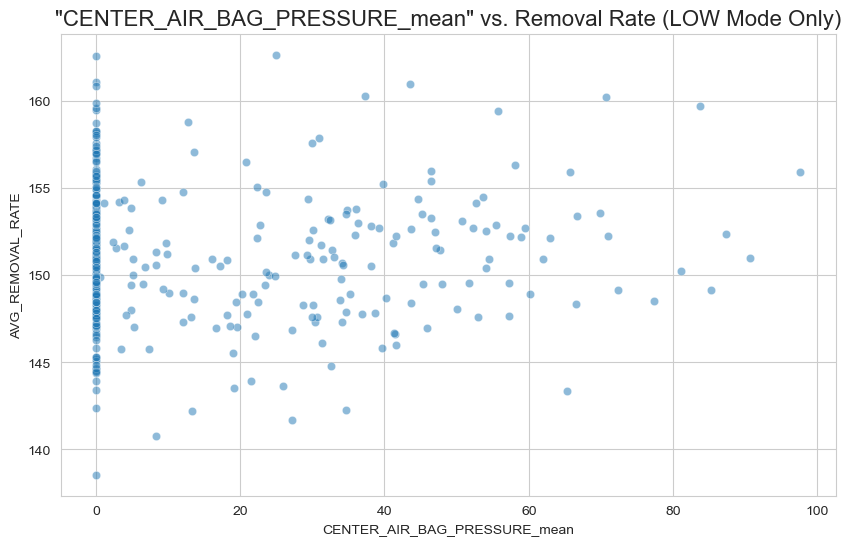


--- Investigating Regression Trends for MEDIUM Mode (120 <= Rate < 4000) ---


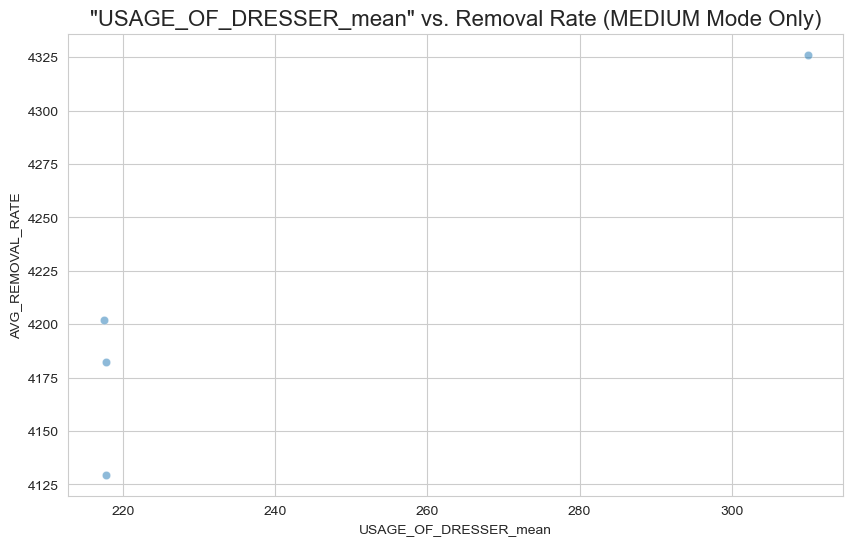

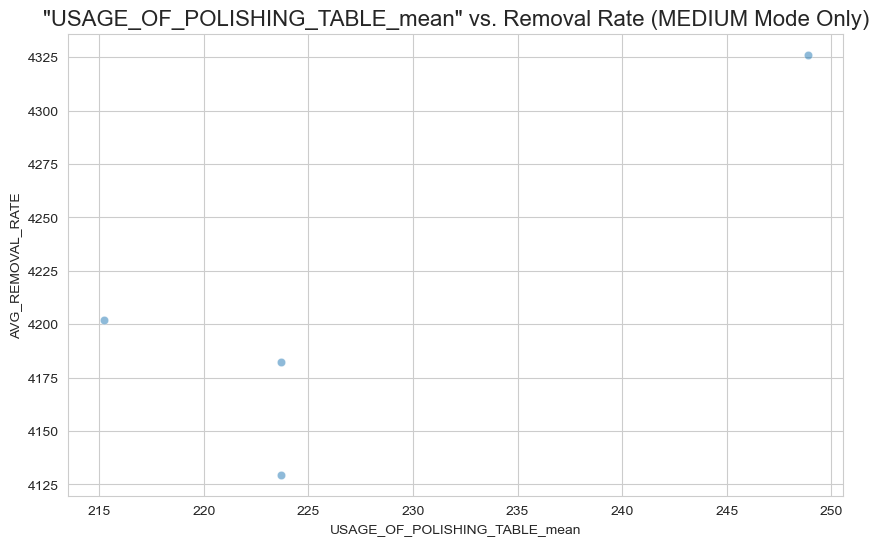

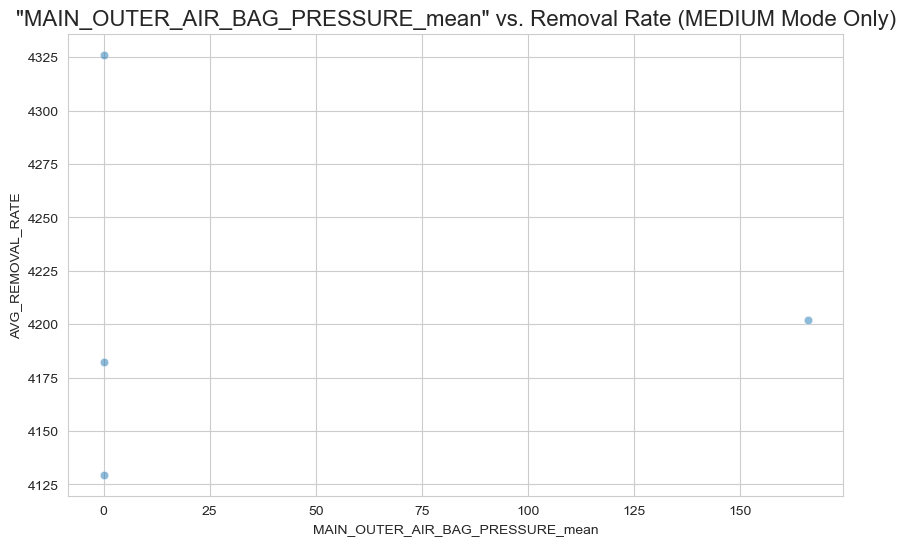

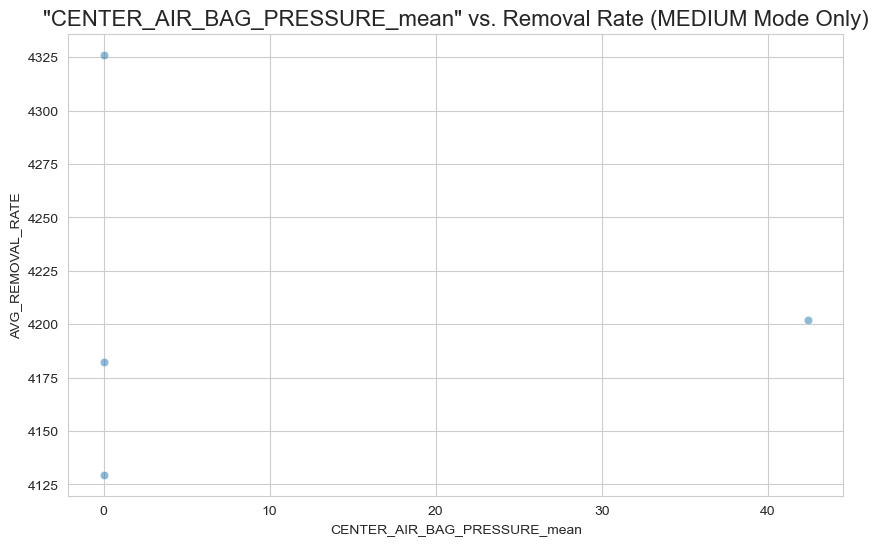

In [41]:
# Create separate DataFrames for the Low and Medium modes
low_mode_df = analysis_df[analysis_df['REMOVAL_RATE_MODE'] == 1]
medium_mode_df = analysis_df[analysis_df['REMOVAL_RATE_MODE'] == 2]

# Candidate features for our regressors
regressor_candidate_features = [
    'USAGE_OF_DRESSER_mean',
    'USAGE_OF_POLISHING_TABLE_mean',
    'MAIN_OUTER_AIR_BAG_PRESSURE_mean',
    'CENTER_AIR_BAG_PRESSURE_mean'
]

# --- Plot for LOW Mode (Mode 1) ---
print("--- Investigating Regression Trends for LOW Mode (Rate < 120) ---")
for feature in regressor_candidate_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=low_mode_df, x=feature, y='AVG_REMOVAL_RATE', alpha=0.5)
    plt.title(f'"{feature}" vs. Removal Rate (LOW Mode Only)', fontsize=16)
    plt.show()

# --- Plot for MEDIUM Mode (Mode 2) ---
print("\n--- Investigating Regression Trends for MEDIUM Mode (120 <= Rate < 4000) ---")
for feature in regressor_candidate_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=medium_mode_df, x=feature, y='AVG_REMOVAL_RATE', alpha=0.5)
    plt.title(f'"{feature}" vs. Removal Rate (MEDIUM Mode Only)', fontsize=16)
    plt.show()